# About
This is a topic notebook made by Guillaume GOYON.  
It is tested on wikipedia pages.

# Topic modeling algorithms
These are the different algorithms found for doing topic modeling.

## Cosine similarity
This is a simple model : every document is encoded by a count of it's words : this makes a vector. Then we use the cosine as a distance betsween 2 documents and perform a clustering on the obtained graph.

## Restricted Blotzmann machine
This uses a probabilistic model to learn latent hidden variables. It has the structure of a neural network.  
We use it to encode the documents in a low dimensional latent space, which represents the topics.

## Latent Semantic Analysis (LSA)
This is basically an analysis of the main correlation between documents and terms inside them using the term frequency-inverse document frequency metric.  
The correlation is found using a singular value decomposition.

## Probabilistic Latent Semantic Analysis (pLDA)
This uses a probabilistic model to improve LSA. However it is not used often because LDA gives better result.

## Latent Dirichlet Allocation (LDA)
This one is a probabilistic model based on a generative assumption : text data have been made after picking a topic for them.  
This is a very good algorithm when it comes to analyze topics.  

## LDA2vec
LDA2vec is a deep learning approach of the LDA, mixed with word embedding. [Implementation here](https://github.com/meereeum/lda2vec-tf)

# Implementation
We will implement LSA and LDA.

## Modules used
* os
* matplotlib
* numpy
* sklearn
* nltk
* pypdf2
* textract

## Data importation
A few data format is supported. One can add more if needeed.  
So far :
* .txt
* .doc
* .docx
* .pdf

In [1]:
import os
import PyPDF2
import textract

data_dir = './wikipedia_pages'

texts = []

#% Read files and store them in texts
for file in os.listdir(data_dir):
    #% Text files
    if file.endswith('.txt'):
        f = open(os.path.join(data_dir, file), 'r', encoding='utf8')
        texts.append(f.read())
        f.close()
    #% PDF files
    elif file.endswith('.pdf'):
        f = open(os.path.join(data_dir, file), 'rb')
        fileReader = PyPDF2.PdfFileReader(f)
        text = ""
        for p in range(fileReader.numPages):
            text += fileReader.getPage(p).extractText()
            texts.append(text)
        f.close()
    #% Doc files
    elif file.endswith('.doc') or file.endswith('.docx'):
        texts.append(textract.process(os.path.join(data_dir, file)))
    #% Unsupported files
    else:
        print(file, 'Unsupported format')

## PreProcessing stages
Here are several pre-processing that have been done :
* filter unwanted characters (punctiation, quotes)
* stem the dataset (remove the suffix)
* filter rare and common words

The last 2 steps are essentials to reduce the dimension of the vocabulary used. Too much vocabulary leads to slow and unefficient learning. OneI could also have used lemmatisation, but this is less cost-friendly regarding computational time, especially if we have a lot of documents.

For the rare words, words that are in few documents (2 or less) are removed because these are not meaningful for this task. (these may even bring a lot of noise in the topic classification)
Also, since the methods tested are not dependant on the order of the words, the most common words (in more than half the dataset) are also removed.

In [2]:
from nltk import SnowballStemmer

def filter_text(text, filtered=",.:\"()_-\\/=[]"):
    """
    Filters characters from a text (it replaces these by spaces)
    """
    text_filtered = text
    for filtered_char in filtered:
        text_filtered = text_filtered.replace(filtered_char, ' ')
    return text_filtered

def build_corpus_dictionnary(corpus):
    """
    Builds a dictionnary of documents containing a given word
    """
    dic = {}
    for text_id, text in enumerate(corpus):
        for word in text:
            if not dic.get(word):
                dic[word] = set()
            dic[word].add(text_id)
    return dic

stemmer = SnowballStemmer("english")

def stem_text(text, stemmer_dict = None):
    """
    Stems a text
    Keeps track of the translations in the stemmer_dict if specified
    """
    result = []
    for word in text:
        stemmed = stemmer.stem(word)
        if stemmer_dict is not None:
            if not stemmer_dict.get(stemmed):
                stemmer_dict[stemmed] = {}
            if not stemmer_dict[stemmed].get(word):
                stemmer_dict[stemmed][word] = 0
            stemmer_dict[stemmed][word] += 1
        result.append(stemmed)
    return result

def filter_words(texts, words_filtered):
    """
    Filter words from the argument list on the text
    """
    return list(map(lambda text:[word for word in text if word not in words_filtered], texts))

class CustomPreprocessingStage():
    """
    This stage has been designed to be usable by sklearn Pipeline.
    This makes it easier to use and enables devs to write lighter code
    """
    def __init__(self, rare_words_rate, common_words_rate):
        """
        rare_words_rate : ratio of the words that are considered as rare words
        common_words_rate : ratio of the words that are considered as common words
        e.g. 0.01 means that words that appear in less than 1% of the documents will be removed
        """
        self.rare_words_rate = rare_words_rate
        self.common_words_rate = common_words_rate
        
        #% This is a dictionnary that keeps track of the stemmed words.
        ## It can be used to recover words from the stemmed version
        self.stemmer_dict = {}
        return
    
    def fit(self, texts, y=None):
        """
        Fits the stage.
        texts : a list of texts.
        y is essential for use within the pipeline.
        """
        #% Filter dataset
        texts = list(map(filter_text, texts))
        #% Split
        texts = list(map(lambda t : t.lower().split(), texts))
        #% Stem texts
        texts = list(map(lambda text : stem_text(text, self.stemmer_dict), texts))
        #% Filter rare words (in only 1 text)
        
        corpus_dic = build_corpus_dictionnary(texts)
        self.filtered = [w for w in corpus_dic if len(corpus_dic[w]) <= self.rare_words_rate * len(texts)]
        self.filtered += [w for w in corpus_dic if len(corpus_dic[w]) > self.common_words_rate * len(texts)]
        self.transformed_texts = texts
        return self
    
    def transform(self, texts):
        """
        Transforms the argument with the learned pattern
        """
        #% Filter dataset
        texts = list(map(filter_text, texts))
        #% Split
        texts = list(map(lambda t : t.split(), texts))
        #% Stem texts
        texts = list(map(stem_text, texts))
        #% Filter rare words (in only 1 text)
        texts = filter_words(texts, self.filtered)
        #% Rebuild strings
        texts = list(map(lambda text : ' '.join(text), texts))
        return texts
    
    def fit_transform(self, texts, y=None):
        """
        Fits the stage and transforms the input
        texts : a list of texts.
        y is essential for use within the pipeline.
        """
        self.fit(texts)
        texts = filter_words(self.transformed_texts, self.filtered)
        #% Rebuild strings
        return list(map(lambda text : ' '.join(text), texts))

## Splitting data
This let us test the algorithm on unseen data.

In [3]:
from sklearn.model_selection import train_test_split
texts_train, texts_test = train_test_split(texts, test_size=0.1, random_state=1)

## LSA Model
### Implementation
This is the implementation of the LSA model.  
It performs a Singular Value Decomposition on the TF-IDF.  

For this, we have picked 10 topics.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

number_of_topics = 10

#% Stage 1 : pre-processing
prep = CustomPreprocessingStage(rare_words_rate = 0.02, common_words_rate = 0.5)

#% Stage 2 : TF-IDF
tf_idv_vectorizer =  TfidfVectorizer(lowercase=True, stop_words='english')

#% Stage 3 : SVD
svd_model = TruncatedSVD(n_components=number_of_topics, n_iter=100, random_state=1)

#% Pipeline
pipe = Pipeline([('preprocessing', prep), ('tf_idf', tf_idv_vectorizer), ('svd', svd_model)])

pipe = pipe.fit(texts_train, None) # No labels for topic modeling 

### Post-fit analysis
#### Topics
Here, we can see the word associated with every topic

In [5]:
def build_topics(terms, components, stemmer_dict):
    """
    Build a list of terms belonging to each topic.
    terms : the words (before tokenisation)
    components : the weight of each term in the topics
    stemmer_dict : dictionnary of the unstemmed words
    """
    topics = []

    for i, component in enumerate(components):
        terms_comp = zip(terms, component)
        #% Keep the first 10 terms
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
        #% Recover the pre-stemming word
        sorted_words = [max(prep.stemmer_dict[w[0]], key=prep.stemmer_dict[w[0]].get) for w in sorted_terms]
        topics.append(sorted_words)
        print('Topic {} : {}'.format(str(i), ', '.join(t for t in sorted_words)))
    
    return topics

In [6]:
terms = tf_idv_vectorizer.get_feature_names()

topics = build_topics(terms, svd_model.components_, prep.stemmer_dict)

Topic 0 : city, york, church, museum, school, film, paris, team, art, library
Topic 1 : team, players, ball, football, season, school, game, cup, club, played
Topic 2 : film, festival, divergent, news, star, usa, fox, highlander, 01, television
Topic 3 : water, snow, clouds, species, surface, drinks, plants, windows, flame, leaf
Topic 4 : church, film, catholic, pope, cardinal, festival, cathedral, bishops, christian, building
Topic 5 : film, city, festival, lima, york, water, park, divergent, usa, 01
Topic 6 : school, art, museum, isbn, 978, klein, water, barcelona, miller, cleveland
Topic 7 : school, klein, district, elementary, varsity, manos, trenton, church, montana, students
Topic 8 : york, fox, news, city, television, award, mafia, american, clinton, chamberlain
Topic 9 : library, ball, museum, bank, company, data, sir, shanghai, set, personal


#### Clustering of the input texts
T-SNE is an algorithm designed to reduce high-dimentional data to be able to visualize it.  
Here we take data from the topic space and we plot it in 2 dimensions.

In [7]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

#% Encode texts and transform data
texts_encoded = pipe.transform(texts_train)
tsne_model = TSNE(n_components=2, random_state=1, init='pca')
tsne_lda = tsne_model.fit_transform(texts_encoded)

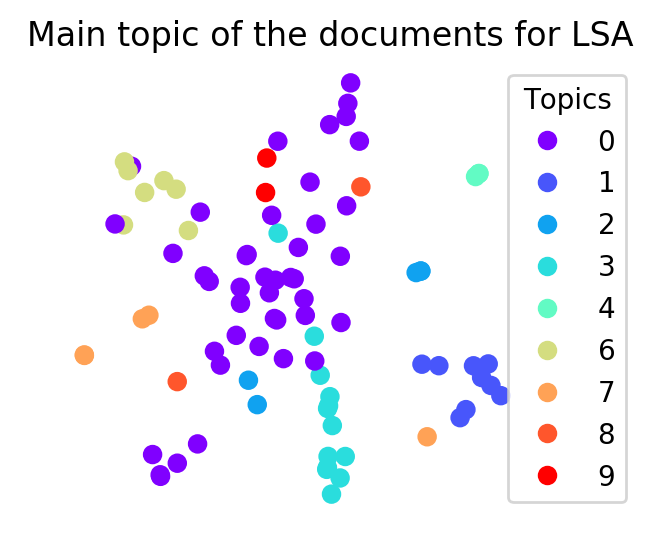

In [8]:
labels = np.argmax(texts_encoded, axis=1)
#% Plot, leave space for legend
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

scatter = plt.scatter(tsne_lda[:,0], tsne_lda[:,1], c=labels, cmap='rainbow')
ax.set_xlim((min(tsne_lda[:,0])*1.3, max(tsne_lda[:,0])*1.1+3))

legend1 = ax.legend(*scatter.legend_elements(), loc="right", title="Topics")
plt.axis('off')
plt.title('Main topic of the documents for LSA')
plt.savefig('images/tsne_lsa.png')
plt.show()

#### New data
We can also try to tag unseen data.  
For this, we build a graph representing how close this subject is to every topic.  
I scaled the output so we can see more clearly the relation between the data and every topic

In [9]:
unseen_data = texts_test[0]
print(unseen_data[:1000])

Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,731,571 as of 2016. Current to 2016, the Toronto census metropolitan area (CMA), of which the majority is within the Greater Toronto Area (GTA), held a population of 5,928,040, making it Canada's most populous CMA. The city is the anchor of the Golden Horseshoe, an urban agglomeration of  9,245,438 people (as of 2016) surrounding the western end of Lake Ontario. Toronto is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.People have travelled through and inhabited the Toronto area, located on a broad sloping plateau interspersed with rivers, deep ravines, and urban forest, for more than 10,000 years. After the broadly disputed Toronto Purchase, when the Mississauga surrendered the area to the British Crown, the British established the town of York in 1793 and later designated it 

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def scaled_sigmoid(x):
    x = x.reshape(-1, 1)
    return 1 / (1 + np.exp(-5 * (x - 0.3)))

def softmax(x):
    x = x.reshape(-1, 1)
    return np.exp(x)/sum(np.exp(x))

def plot_data_topic_relation(data, topics, save_file=None):
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    ax.cla()
    circle1 = plt.Circle((0, 0), 1, color='r', fill=False, linewidth=0.5)
    ax.set_xlim((-1.1, 1.5))
    ax.set_ylim((-1.1, 1.1))
    plt.axis('off')
    ax.add_artist(circle1)

    features_match = scaled_sigmoid(data)

    topic_pos = []
    for i in range(len(topics)):
        angle = 2 * np.pi * i / len(topics)
        topic_pos.append(np.array([np.cos(angle), np.sin(angle)]))

        plt.scatter(topic_pos[i][0], topic_pos[i][1], color='r')

        plt.text(topic_pos[i][0], topic_pos[i][1], topics[i][0:2], fontsize=6)
        plt.plot((0, topic_pos[i][0]), (0, topic_pos[i][1]), 'grey', linewidth=0.5)

    poly = np.array(topic_pos * features_match)
    plt.fill(poly[:,0], poly[:,1])
    if save_file is not None:
        plt.savefig(save_file)

    plt.show()

Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,731,571 as of 2016. Current to 2016, the Toronto census metropolitan area (CMA), of which the majority is within the Greater Toronto Area (GTA), held a population of 5,928,040, making it Canada's most populous CMA. The city is the anchor of the Golden Horseshoe, an urban agglomeration of  9,245,438 people (as of 2016) surrounding the western end of Lake Ontario. Toronto is an international c


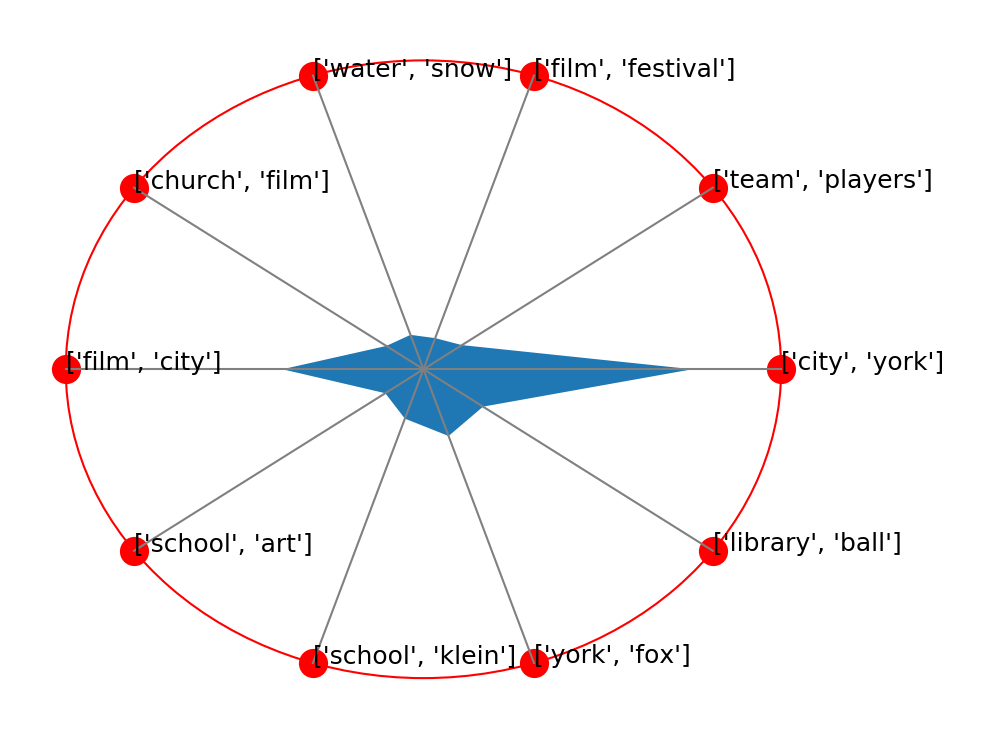

A school is an educational institution designed to provide learning spaces and learning environments for the teaching of students (or "pupils") under the direction of teachers. Most countries have systems of formal education, which is commonly compulsory. In these systems, students progress through a series of schools. The names for these schools vary by country (discussed in the Regional section below) but generally include primary school for young children and secondary school for teenagers wh


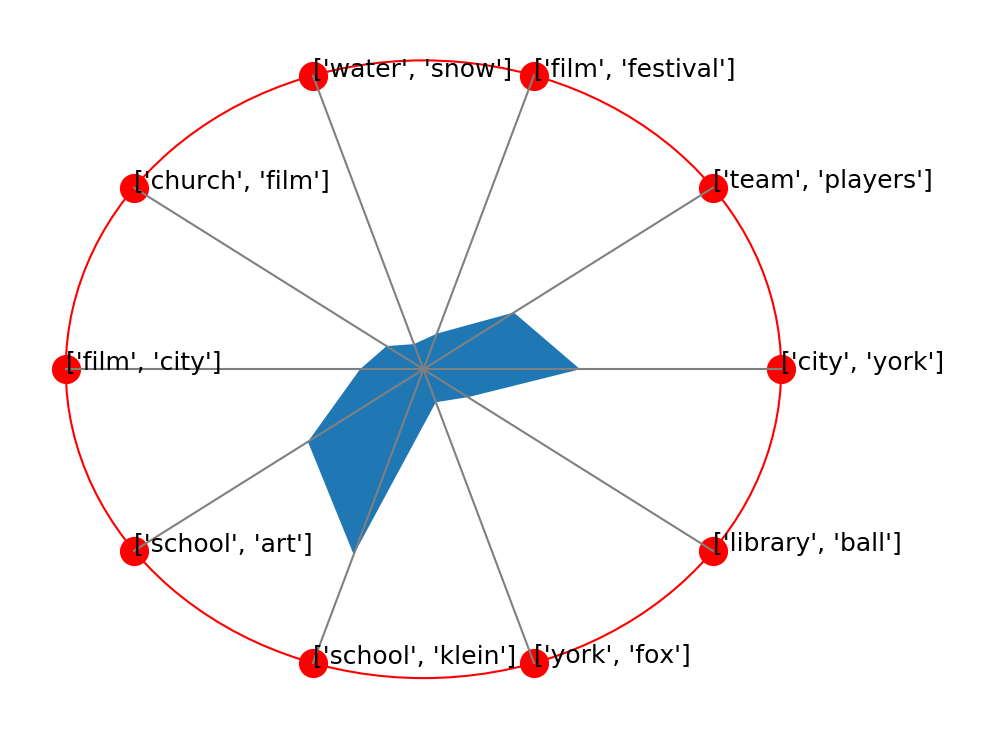

Gamaran (我間乱, Romanized as GAMARAN in Japan) is a Japanese shōnen manga series written and illustrated by Nakamaru Yousuke. Gamaran chronicles the adventures of Kurogane Gama as he competes in the Grand Tournament of Unabara. Facing many opponents with powerful weapons and techniques, Gama must use all his skills in his quest to become the greatest swordsman in the land.
Gamaran was serialized in the Japanese manga anthology Weekly Shōnen Magazine with twenty-two tankōbon volumes released.


== 


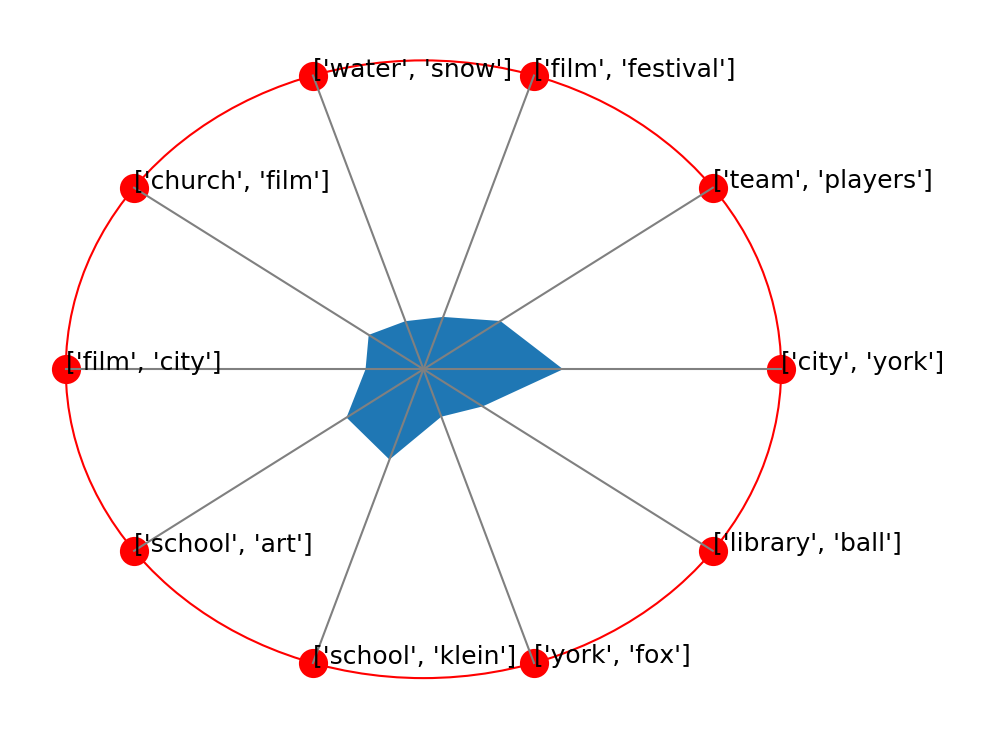

The cuisine of Rwanda is based on local staple foods produced by the traditional subsistence-level agriculture and has historically varied between the country's different ethnic groups.


== Background ==
Rwandan staples include bananas, plantains, pulses, sweet potatoes, beans, and cassava (manioc). Historically this is particularly true of the Twa and the Hutus who hunted and farmed. Their diet was high in vegetables and lacking in animal protein due to the small amount of animal products cons


Robert John Downey Jr. (born April 4, 1965) is an American actor, producer, and singer. His career has been characterized by critical and popular success in his youth, followed by a period of substance abuse and legal troubles, before a resurgence of commercial success in middle age. In 2008, Downey was named by Time magazine among the 100 most influential people in the world, and from 2013 to 2015, he was listed by Forbes as Hollywood's highest-paid actor. His films have grossed over $14.4 bill


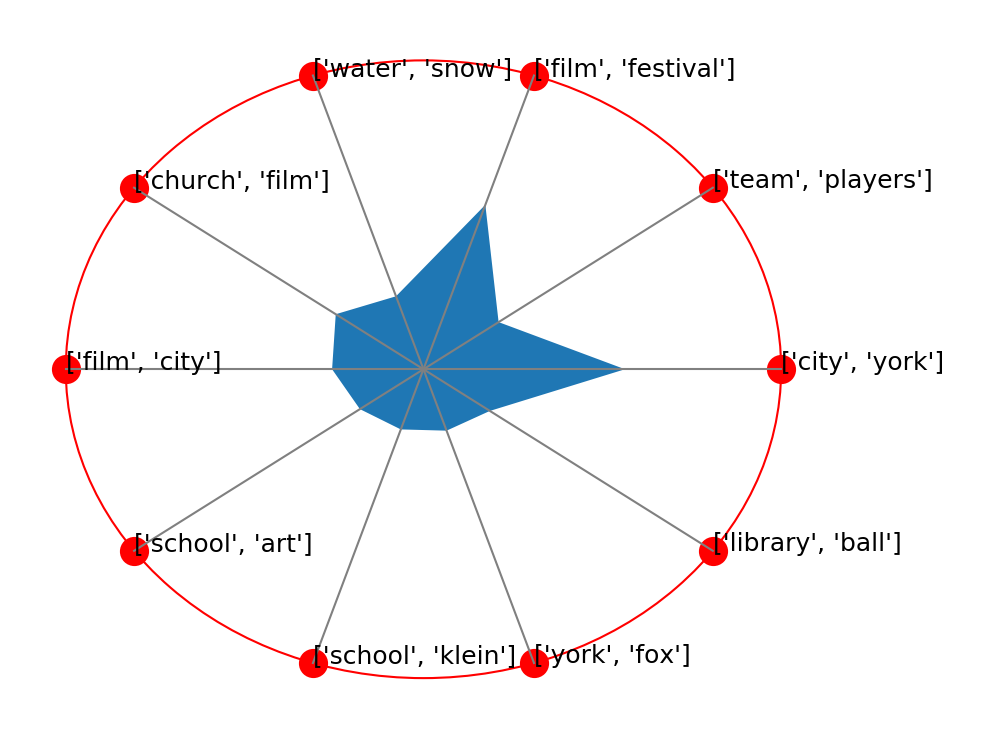

In [11]:
for i in range(5):
    print(texts_test[i][:500])
    plot_data_topic_relation(pipe.transform([texts_test[i]]), topics, 'images/test'+str(i)+'_lsa.png')
    print('==========================================================')

## LDA Model
### Implementation
This is the implementation of the LDA model.
Basically, it tries to fit a probabilistic generative model.

For this, we have picked 5 topics.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
number_of_topics = 10

#% Stage 1 : pre-processing
prep = CustomPreprocessingStage(rare_words_rate = 0.02, common_words_rate = 0.5)

#% Stage 2 : CV
cv =  CountVectorizer(lowercase=True, stop_words='english')

#% Stage 3 : LDA
lda_model = LatentDirichletAllocation(n_components=number_of_topics, learning_method='batch', max_iter=10, random_state=1, n_jobs=-1)

#% Pipeline
pipe = Pipeline([('preprocessing', prep), ('cv', cv), ('lda', lda_model)])

pipe = pipe.fit(texts_train, None) # No labels for topic modeling 

### Post-fit analysis
#### Topics
Here, we can see the word associated with every topic

In [13]:
terms = cv.get_feature_names()

topics = build_topics(terms, lda_model.components_, prep.stemmer_dict)

Topic 0 : paris, city, france, french, la, percent, region, saint, 000, million
Topic 1 : drive, drinks, data, flash, memory, write, factors, form, trim, performance
Topic 2 : hockey, film, chamberlain, economist, game, season, appearance, played, 2014, team
Topic 3 : city, york, clouds, snow, area, park, 000, form, largest, manhattan
Topic 4 : bbc, broadcast, radio, service, television, channel, school, programmes, news, music
Topic 5 : water, lima, city, district, san, area, located, people, spanish, temperature
Topic 6 : clinton, news, fox, election, personal, president, house, report, political, trump
Topic 7 : stark, man, iron, communion, armor, tony, unmitigated, war, avengers, marvel
Topic 8 : church, ball, catholic, team, players, played, game, football, pope, serve
Topic 9 : museum, library, collection, art, building, exhibition, institutions, historic, designed, objects


#### Clustering of the input texts

In [14]:
from sklearn.manifold import TSNE

#% Transform data using T-SNE
texts_encoded = pipe.transform(texts_train)
tsne_model = TSNE(n_components=2, random_state=1, init='pca')
tsne_lda = tsne_model.fit_transform(texts_encoded)

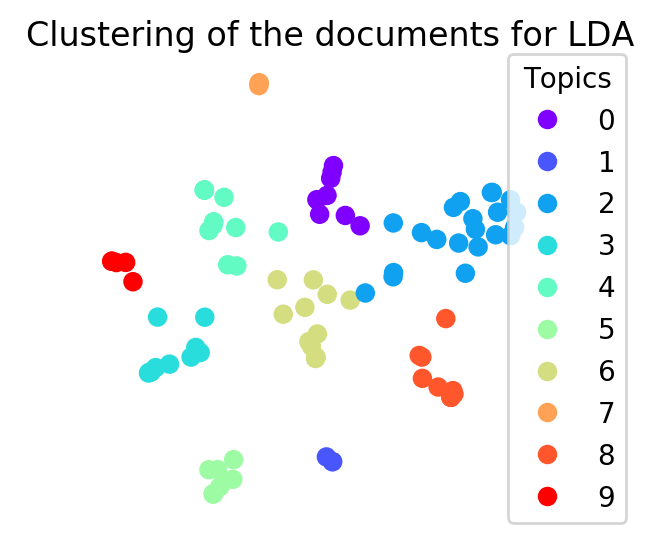

In [15]:
labels = np.argmax(texts_encoded, axis=1)
#% Plot, leave axis for legend
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
scatter = plt.scatter(tsne_lda[:,0], tsne_lda[:,1], c=labels, cmap='rainbow')

ax.set_xlim((min(tsne_lda[:,0])*1.3, max(tsne_lda[:,0])*1.1+3))
legend1 = ax.legend(*scatter.legend_elements(), loc="right", title="Topics")
plt.axis('off')
plt.title('Clustering of the documents for LDA')
plt.savefig('images/tsne_lda.png')

plt.show()

#### New data
We can also try to tag unseen data.  
For this, we build a graph representing how close this subject is to every topic.  
I scaled the output so we can see more clearly the relation between the data and every topic

Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,731,571 as of 2016. Current to 2016, the Toronto census metropolitan area (CMA), of which the majority is within the Greater Toronto Area (GTA), held a population of 5,928,040, making it Canada's most populous CMA. The city is the anchor of the Golden Horseshoe, an urban agglomeration of  9,245,438 people (as of 2016) surrounding the western end of Lake Ontario. Toronto is an international c


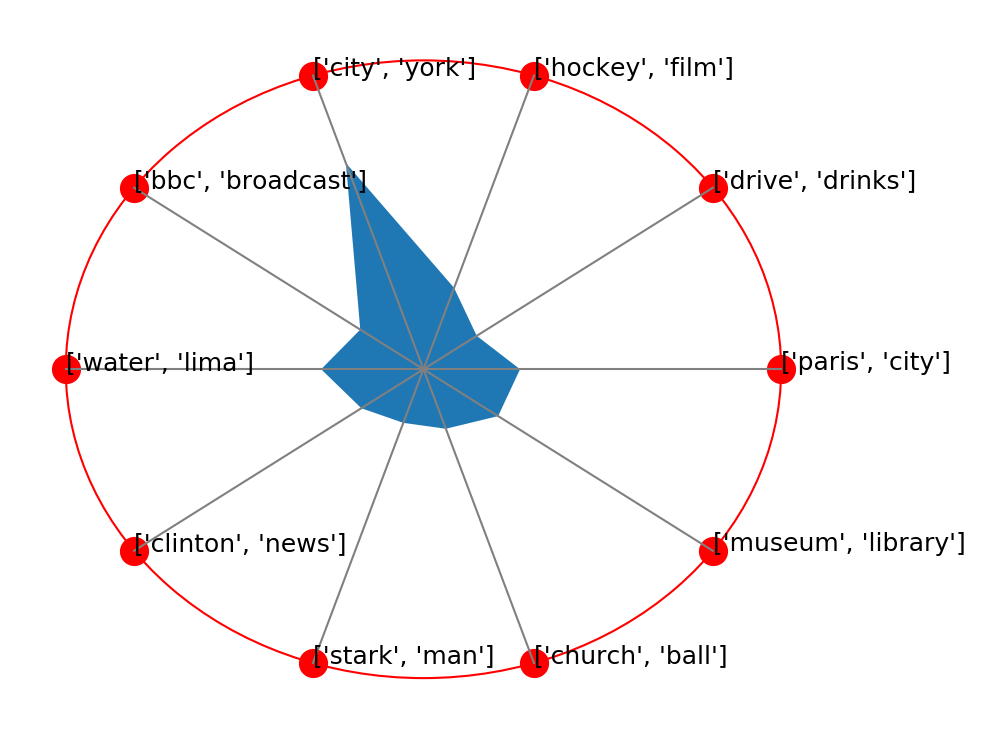

A school is an educational institution designed to provide learning spaces and learning environments for the teaching of students (or "pupils") under the direction of teachers. Most countries have systems of formal education, which is commonly compulsory. In these systems, students progress through a series of schools. The names for these schools vary by country (discussed in the Regional section below) but generally include primary school for young children and secondary school for teenagers wh


Gamaran (我間乱, Romanized as GAMARAN in Japan) is a Japanese shōnen manga series written and illustrated by Nakamaru Yousuke. Gamaran chronicles the adventures of Kurogane Gama as he competes in the Grand Tournament of Unabara. Facing many opponents with powerful weapons and techniques, Gama must use all his skills in his quest to become the greatest swordsman in the land.
Gamaran was serialized in the Japanese manga anthology Weekly Shōnen Magazine with twenty-two tankōbon volumes released.


== 


The cuisine of Rwanda is based on local staple foods produced by the traditional subsistence-level agriculture and has historically varied between the country's different ethnic groups.


== Background ==
Rwandan staples include bananas, plantains, pulses, sweet potatoes, beans, and cassava (manioc). Historically this is particularly true of the Twa and the Hutus who hunted and farmed. Their diet was high in vegetables and lacking in animal protein due to the small amount of animal products cons


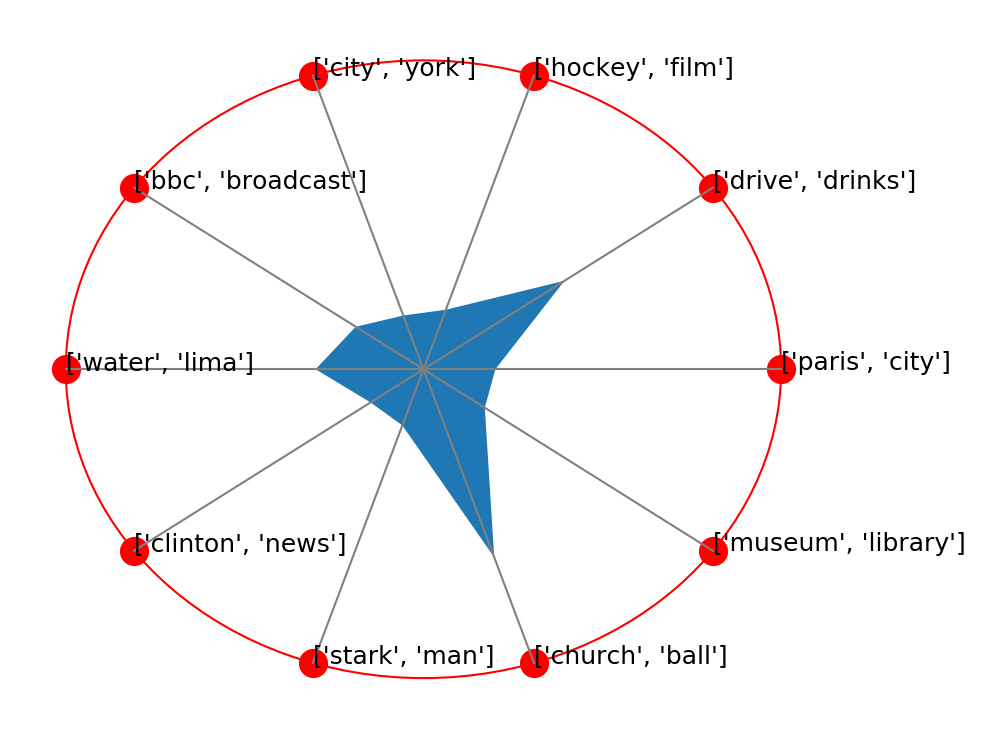

Robert John Downey Jr. (born April 4, 1965) is an American actor, producer, and singer. His career has been characterized by critical and popular success in his youth, followed by a period of substance abuse and legal troubles, before a resurgence of commercial success in middle age. In 2008, Downey was named by Time magazine among the 100 most influential people in the world, and from 2013 to 2015, he was listed by Forbes as Hollywood's highest-paid actor. His films have grossed over $14.4 bill


In [16]:
for i in range(5):
    print(texts_test[i][:500])
    plot_data_topic_relation(pipe.transform([texts_test[i]]), topics, 'images/test'+str(i)+'_lda.png')
    print('==========================================================')